1. Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

2. Load and Preprocess Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the images to 32x32 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# For this example, we'll use the CIFAR-10 dataset. Replace this with your butterfly and insect dataset.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


3. Define the CNN Model

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 10)  # Output layer (10 classes for CIFAR-10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first convolution, ReLU, and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second convolution, ReLU, and pooling
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = torch.relu(self.fc1(x))  # Apply first fully connected layer and ReLU
        x = self.fc2(x)  # Apply output layer
        return x

net = SimpleCNN()

4. Define Loss Function and Optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


5. Train the Model

In [5]:
for epoch in range(10):  # Number of epochs to train
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data  # Get the inputs and labels from the DataLoader
        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = net(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


[1, 100] loss: 1.860
[1, 200] loss: 1.533
[1, 300] loss: 1.469
[1, 400] loss: 1.379
[1, 500] loss: 1.305
[1, 600] loss: 1.255
[1, 700] loss: 1.177
[1, 800] loss: 1.144
[1, 900] loss: 1.117
[1, 1000] loss: 1.113
[1, 1100] loss: 1.088
[1, 1200] loss: 1.050
[1, 1300] loss: 1.047
[1, 1400] loss: 0.999
[1, 1500] loss: 0.988
[2, 100] loss: 0.916
[2, 200] loss: 0.858
[2, 300] loss: 0.895
[2, 400] loss: 0.881
[2, 500] loss: 0.843
[2, 600] loss: 0.870
[2, 700] loss: 0.833
[2, 800] loss: 0.821
[2, 900] loss: 0.840
[2, 1000] loss: 0.840
[2, 1100] loss: 0.803
[2, 1200] loss: 0.838
[2, 1300] loss: 0.824
[2, 1400] loss: 0.824
[2, 1500] loss: 0.762
[3, 100] loss: 0.638
[3, 200] loss: 0.638
[3, 300] loss: 0.630
[3, 400] loss: 0.638
[3, 500] loss: 0.651
[3, 600] loss: 0.666
[3, 700] loss: 0.629
[3, 800] loss: 0.638
[3, 900] loss: 0.645
[3, 1000] loss: 0.662
[3, 1100] loss: 0.662
[3, 1200] loss: 0.632
[3, 1300] loss: 0.622
[3, 1400] loss: 0.650
[3, 1500] loss: 0.632
[4, 100] loss: 0.452
[4, 200] loss: 0

6. Test the Model

In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data  # Get the images and labels from the DataLoader
        outputs = net(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%")


Accuracy of the network on the 10000 test images: 72.22%


7. Visualize Test Samples and Predictions

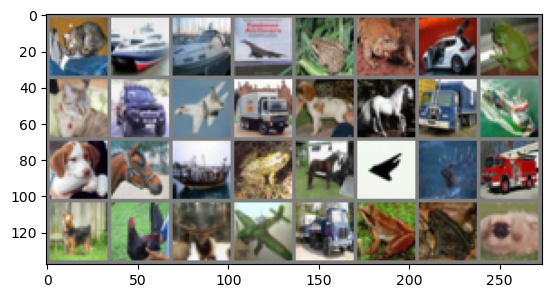

GroundTruth:    cat  ship  ship airplane
Predicted:    cat  ship  ship airplane


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)  # Use the next function to get the next batch of images and labels

# Show images
imshow(torchvision.utils.make_grid(images))

# Print ground truth
print('GroundTruth: ', ' '.join('%5s' % trainset.classes[labels[j]] for j in range(4)))

# Print predictions
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % trainset.classes[predicted[j]] for j in range(4)))
